Train#=371822 Test#=112548
Labels=[0.0, 1.0]
GB best for 1000 trees (d=7 and lr=0.9


<Figure size 600x450 with 0 Axes>

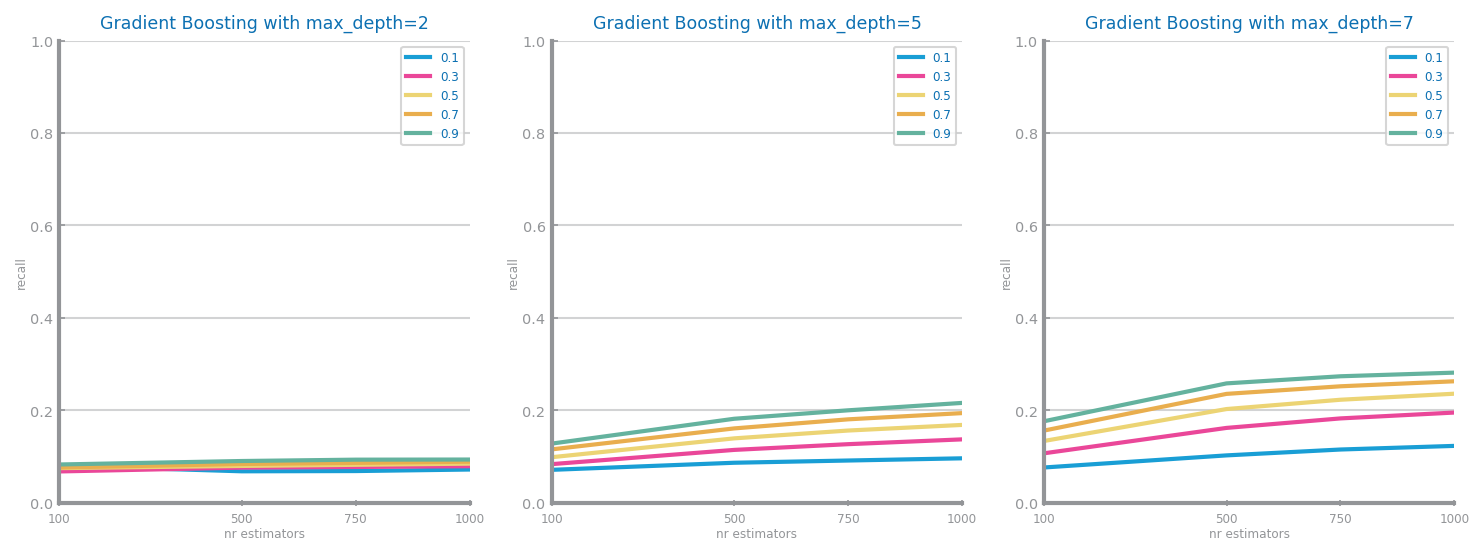

In [1]:
from numpy import array, ndarray
from matplotlib.pyplot import subplots, figure, savefig, show
from sklearn.ensemble import GradientBoostingClassifier
from dslabs_functions import (
    CLASS_EVAL_METRICS,
    DELTA_IMPROVE,
    read_train_test_from_files,
)
from dslabs_functions import HEIGHT, plot_evaluation_results, plot_multiline_chart


def gradient_boosting_study(
    trnX: ndarray,
    trnY: array,
    tstX: ndarray,
    tstY: array,
    nr_max_trees: int = 2500,
    lag: int = 500,
    metric: str = "recall",
) -> tuple[GradientBoostingClassifier | None, dict]:
    n_estimators: list[int] = [100] + [i for i in range(500, nr_max_trees + 1, lag)]
    max_depths: list[int] = [2, 5, 7]
    learning_rates: list[float] = [0.1, 0.3, 0.5, 0.7, 0.9]

    best_model: GradientBoostingClassifier | None = None
    best_params: dict = {"name": "GB", "metric": metric, "params": ()}
    best_performance: float = 0.0

    values: dict = {}
    cols: int = len(max_depths)
    _, axs = subplots(1, cols, figsize=(cols * HEIGHT, HEIGHT), squeeze=False)
    for i in range(len(max_depths)):
        d: int = max_depths[i]
        values = {}
        for lr in learning_rates:
            y_tst_values: list[float] = []
            for n in n_estimators:
                clf = GradientBoostingClassifier(
                    n_estimators=n, max_depth=d, learning_rate=lr
                )
                clf.fit(trnX, trnY)
                prdY: array = clf.predict(tstX)
                eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
                y_tst_values.append(eval)
                if eval - best_performance > DELTA_IMPROVE:
                    best_performance = eval
                    best_params["params"] = (d, lr, n)
                    best_model = clf
                # print(f'GB d={d} lr={lr} n={n}')
            values[lr] = y_tst_values
        plot_multiline_chart(
            n_estimators,
            values,
            ax=axs[0, i],
            title=f"Gradient Boosting with max_depth={d}",
            xlabel="nr estimators",
            ylabel=metric,
            percentage=True,
        )
    print(
        f'GB best for {best_params["params"][2]} trees (d={best_params["params"][0]} and lr={best_params["params"][1]}'
    )

    return best_model, best_params


file_tag = "class_pos_covid"
train_filename = f"data/{file_tag}_train_smote.csv"
test_filename = f"data/{file_tag}_test.csv"
target = "CovidPos"
eval_metric = "recall"


trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(
    train_filename, test_filename, target
)
print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")

figure()
best_model, params = gradient_boosting_study(
    trnX,
    trnY,
    tstX,
    tstY,
    nr_max_trees=1000,
    lag=250,
    metric=eval_metric,
)
# savefig(f"images/{file_tag}_gb_{eval_metric}_study.png")
# show()

array([<Axes: >,
       <Axes: title={'center': 'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>],
      dtype=object)

<Figure size 600x450 with 0 Axes>

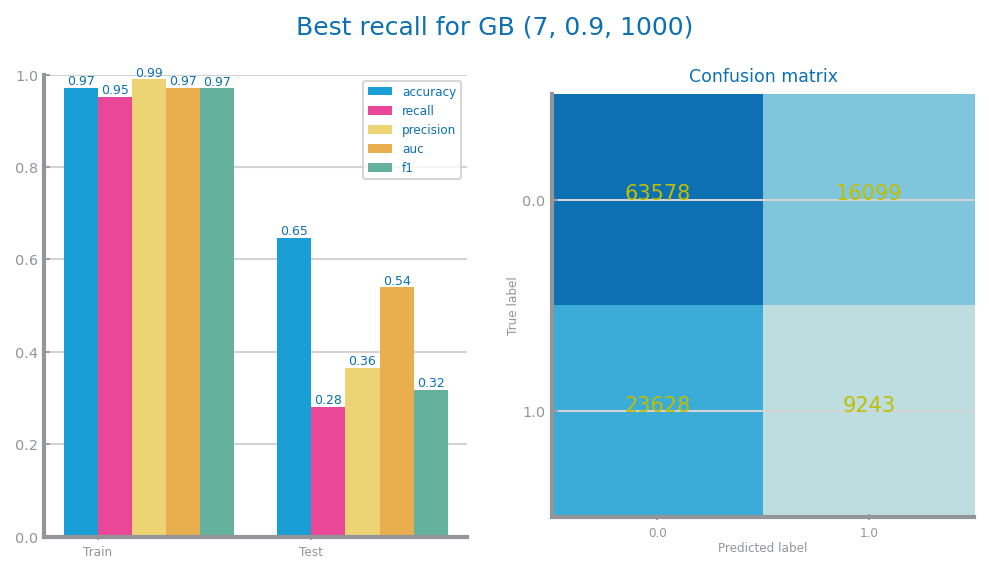

In [4]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
# savefig(f'images/{file_tag}_gb_{params["name"]}_best_{params["metric"]}_eval.png')
# show()

1. ChestScan (0.12126844710728138)
2. BMI (0.108009626572502)
3. AlcoholDrinkers (0.10740820989200661)
4. AgeCategory (0.09433226923053765)
5. FluVaxLast12 (0.08582166673342412)
6. SleepHours (0.07816771313106705)
7. HIVTesting (0.05994754661501315)
8. SmokerStatus (0.03988162169302861)
9. TetanusLast10Tdap (0.03567691672498779)
10. HadArthritis (0.03171266379626502)
11. PhysicalHealthDays (0.030039391845897434)
12. MentalHealthDays (0.02702858375140141)
13. LastCheckupTime (0.026144438782689017)
14. RemovedTeeth (0.02089589139244386)
15. GeneralHealth (0.019824418515657555)
16. HadAsthma (0.01409777016851472)
17. PneumoVaxEver (0.013151371009623007)
18. ECigaretteUsage (0.01173549603038813)
19. PhysicalActivities (0.011701286524986731)
20. HadDiabetes (0.006712179287463236)
21. DifficultyErrands (0.006553462629413969)
22. DifficultyWalking (0.006362845002764961)
23. HadDepressiveDisorder (0.006199803609414235)
24. HadSkinCancer (0.0048406538780935105)
25. HighRiskLastYear (0.004550129

<Axes: title={'center': 'GB variables importance'}, xlabel='importance', ylabel='variables'>

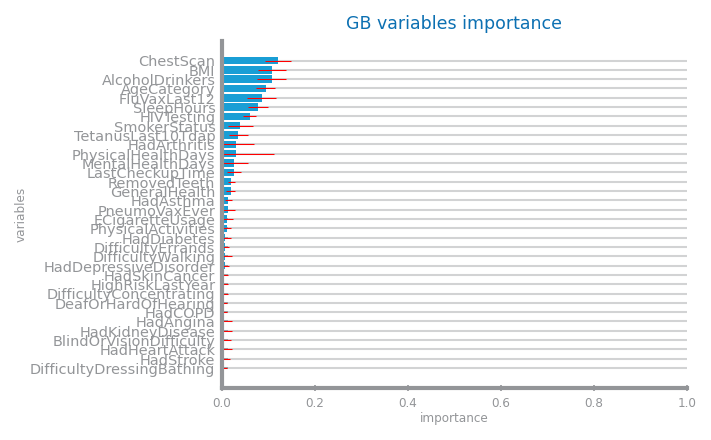

In [2]:
from numpy import std, argsort
from dslabs_functions import plot_horizontal_bar_chart

trees_importances: list[float] = []
for lst_trees in best_model.estimators_:
    for tree in lst_trees:
        trees_importances.append(tree.feature_importances_)

stdevs: list[float] = list(std(trees_importances, axis=0))
importances = best_model.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values.append(importances[indices[f]])
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    error=stdevs,
    title="GB variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
# savefig(f"images/{file_tag}_gb_{eval_metric}_vars_ranking.png")

<Axes: title={'center': 'GB overfitting study for d=7 and lr=0.9'}, xlabel='nr_estimators', ylabel='recall'>

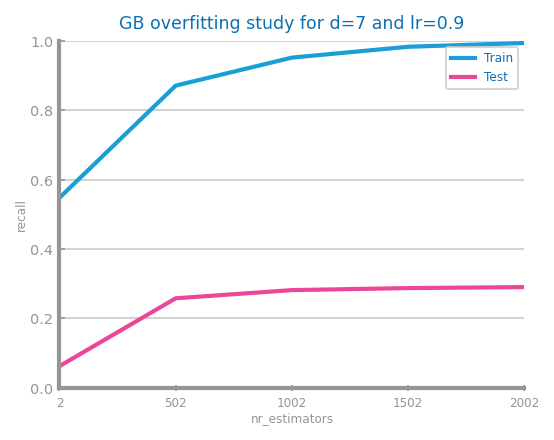

In [3]:
d_max: int = params["params"][0]
lr: float = params["params"][1]
nr_estimators: list[int] = [i for i in range(2, 2501, 500)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric: str = "recall"

for n in nr_estimators:
    clf = GradientBoostingClassifier(n_estimators=n, max_depth=d_max, learning_rate=lr)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    nr_estimators,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"GB overfitting study for d={d_max} and lr={lr}",
    xlabel="nr_estimators",
    ylabel=str(eval_metric),
    percentage=True,
)
# savefig(f"images/{file_tag}_gb_{eval_metric}_overfitting.png")

[Text(0.5, 0.9, 'ECigaretteUsage <= 3.0\nsamples = 371822\nvalue = -0.0'),
 Text(0.25, 0.7, 'BMI <= 29.81\nsamples = 363389\nvalue = -0.0'),
 Text(0.125, 0.5, 'HadDiabetes <= 2.83\nsamples = 239054\nvalue = 0.0'),
 Text(0.0625, 0.3, 'BMI <= 29.8\nsamples = 216971\nvalue = 0.0'),
 Text(0.03125, 0.1, '\n  (...)  \n'),
 Text(0.09375, 0.1, '\n  (...)  \n'),
 Text(0.1875, 0.3, 'HadArthritis <= 0.0\nsamples = 22083\nvalue = 0.0'),
 Text(0.15625, 0.1, '\n  (...)  \n'),
 Text(0.21875, 0.1, '\n  (...)  \n'),
 Text(0.375, 0.5, 'BMI <= 31.6\nsamples = 124335\nvalue = -0.0'),
 Text(0.3125, 0.3, 'LastCheckupTime <= 1.0\nsamples = 31994\nvalue = -0.0'),
 Text(0.28125, 0.1, '\n  (...)  \n'),
 Text(0.34375, 0.1, '\n  (...)  \n'),
 Text(0.4375, 0.3, 'BMI <= 31.8\nsamples = 92341\nvalue = -0.0'),
 Text(0.40625, 0.1, '\n  (...)  \n'),
 Text(0.46875, 0.1, '\n  (...)  \n'),
 Text(0.75, 0.7, 'BMI <= 20.65\nsamples = 8433\nvalue = -0.01'),
 Text(0.625, 0.5, 'MentalHealthDays <= 0.04\nsamples = 724\nvalue = 0

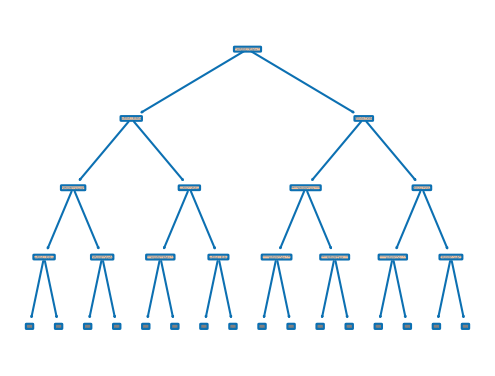

In [5]:

from sklearn.tree import plot_tree
max_depth2show: int = 3
st_labels: list[str] = [str(value) for value in labels]

plot_tree(
    best_model.estimators_[42, 0],
    max_depth=max_depth2show,
    feature_names=vars,
    class_names=st_labels,
    filled=True,
    rounded=True,
    impurity=False,
    precision=2,
)